<center><h1>Multiclass Classification with Backpropagation Neural Network (BPNN)</h1></center>

First, we get the dataset from the sklearn library. We to import the libraries needed to do data preprocessing such as one hot encoder and split train test library. After that, load the dataset into a variable shown below.

In [1]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_digits

digits = load_digits()

After importing and getting data, we process the data so it can perform a multiclass classification. This can be achieved by encoding the target data with one hot encoder. Lastly, we split the dataset by 80% training and 20% testing

In [2]:
def get_dataset():
    dataset_input = digits.data
    dataset_output = digits.target
    
    dataset_output = OneHotEncoder(sparse = False).fit_transform(dataset_output.reshape(-1, 1))
    return dataset_input, dataset_output

dataset_input, dataset_output = get_dataset()

x_train, x_test, y_train, y_test = \
    train_test_split(dataset_input, dataset_output, test_size = 0.2, random_state = 42)


Now, we define the BPNN architecture parameters by identifying the input and output layer needed to perform the training. In the dataset, the image data contains a matrix that represents pixels in the image. we too found that the size of each element in the matrix represents the intensity of the color. After some analysis, it has been found that the dimension of the matrix is 8 x 8. From this we can define the input layer as all pixel of the image, which is 64. Last but not least, we define the learning rate which is alpha.

In [3]:
#init input and output (user input only)
input_layer = 64
output_layer = 10
alph = 0.05

Now, we can define the functions needed for BPNN training. For the initial weights and bias, we use stochastic method to find the parameters needed. We too can make an input that can obtain the amount of hidden layer neuron.

In [4]:
def init(input_layer, output_layer):
    hidden = int(input("Input number of hidden layer: "))
    # input to hidden weights
    w_itoh = np.empty((0, input_layer))
    for i in range(hidden):
        inner_arr = []
        for i in range(input_layer):
            rand = np.array([[np.random.normal(1, 10) * 0.01]])
            inner_arr = np.append(inner_arr, rand)
        inner_arr = np.array([inner_arr])
        w_itoh = np.append(w_itoh, inner_arr, axis = 0)

    # hidden to output weights
    w_htoo = np.empty((0, output_layer))
    for i in range(hidden):
        inner_arr = []
        for i in range(output_layer):
            rand = np.array([[np.random.normal(1, 10) * 0.01]])
            inner_arr = np.append(inner_arr, rand)
        inner_arr = np.array([inner_arr])
        w_htoo = np.append(w_htoo, inner_arr, axis = 0)
    w_htoo = w_htoo.T

    # biases
    b = np.empty((0, 1))
    for i in range(2):
        rand = np.array([[np.random.normal(1, 10) * 0.01]])
        b = np.append(b, rand, axis = 0)

    return hidden, w_itoh, w_htoo, b

The function below has a purpose to calculate the error through the desired output and the predicted output.

In [5]:
def error(output, prediction):
    error = 0.5 * (prediction - output) ** 2
    return error


We make the feed_forward function to predict the data. The input data go through the hidden neurons and lastly to the output. For the activation function, we use logistic sigmoid function defined by the formula below. Before go to the hidden and output neuron each, the net output is squashed using the activation function. 

$ f(x) = sigmoid(x) = \frac{1}{1 + e^{-x}} $

In [6]:
def feed_forward(data_input, w_itoh, w_htoo, bias):
    # input to hidden
    net = []
    for i in range(len(w_itoh)):
        matmul = np.matmul(data_input, w_itoh[i]) + b[0]
        net = np.append(net, matmul)

    activation1 = 1 / (1 + np.exp(-net))
    h1_out = activation1

    # hidden to output
    net2 = []
    for i in range(len(w_htoo)):
        matmul1 = np.matmul(activation1, w_htoo[i]) + b[1]
        net2 = np.append(net2, matmul1)

    output = 1 / (1 + np.exp(-net2))

    #check = np.all(output == output[0])
    #if check:
    #    output = output[0]

    return h1_out, output


For the backpropagation, there are 2 steps of updating all weights in the network, which is output neuron to hidden neuron, and hidden neuron to input. For the weights on the hidden to output, we search for the partial derivatives of the total error in respect of the weights. After some simplification, the formula for updating the weights in hidden - output is defined below.

$ \delta = - (output - prediction) \cdot prediction \cdot (1 - prediction) \\ 
w_{new} = w_{old} - \alpha \cdot out_h \cdot \delta $

After all the weights in hidden - output is updated, we can start to calculate the weights in hidden to input, which is defined by a formula below

$ \delta_{h} = (h_{out}) \cdot (1 - h_{out}) \cdot \delta_o \\
w_{new} = w_{old} - \alpha \delta_{h} \cdot input$

After all the formulas is identified, we can write the function below

In [7]:
def backpropagate(inp, w_itoh, w_htoo, h1_out, pred, output, bias):
    delta = - (output - pred) * pred * (1 - pred)
    w_htoo_temp = w_htoo
    # output to hidden
    for i in range(len(delta)):
        for j in range(len(h1_out)):
            w_htoo[i][j] = w_htoo[i][j] - (alph * h1_out[j] * delta[i])
    # hidden to input
    w_T = w_htoo.T

    w_delta = []
    for i in range(len(w_T)):
        matmul = np.matmul(delta, w_T[i])
        w_delta = np.append(w_delta, matmul)

    hidden_delta = (h1_out) * (1 - h1_out) * w_delta

    for i in range(len(hidden_delta)):
        for j in range(len(inp)):
            w_itoh[i][j] = w_itoh[i][j] - (alph * hidden_delta[i] * inp[j])

    bias = alph * 1 * delta
    return w_itoh, w_htoo, bias


For the parameter initialization, the parameters needed is number of neuron in hidden, input, and output layer, the weights, and bias. For the hidden layer, we input the amount of neuron needed, which is 48

In [8]:
hidden, w_itoh, w_htoo, b = init(input_layer, output_layer)

Input number of hidden layer:  48


Now we can start the training. For this case, the epoch will be 50

In [9]:
data_input = np.array(x_train)
data_output = np.array(y_train)
epoch = 50
input("Press enter to start...")
result = {
    "epoch": [],
    "prediction": [],
    "output": [],
    "error": [],
    "mean_error": []
}
print("-----| Training ... |-----")
for i in range(epoch):
    if (i+1) % 5 == 0:
        print("Epoch = {}".format(i+1))
    for j in range(len(data_input)):
        temp_error = []
        result["epoch"] = np.append(result["epoch"], i)
        h1_out, prediction = feed_forward(data_input[j], w_itoh, w_htoo, b)
        loss = error(data_output[j], prediction)
        result["error"] = np.append(result["error"], np.sum(loss))
        result["prediction"] = np.append(result["prediction"], prediction)
        #print("Prediction = {}, Output = {}".format(prediction, data_output[j]))
        result["output"] = np.append(result["output"], data_output[j])
        w_itoh, w_htoo, b = backpropagate(data_input[j], w_itoh, w_htoo, h1_out, prediction, data_output[j], b)
        temp_error = np.append(temp_error, loss)
        #print("Loss = {}".format(loss))
    mean_error = np.mean(temp_error)
    for i in range(len(data_input)):
        result["mean_error"] = np.append(result["mean_error"], mean_error)

print("-----| Training Finished |-----")

Press enter to start... 


-----| Training ... |-----
Epoch = 5
Epoch = 10
Epoch = 15
Epoch = 20
Epoch = 25
Epoch = 30
Epoch = 35
Epoch = 40
Epoch = 45
Epoch = 50
-----| Training Finished |-----


Now the training is complete, we can show the error curves to validate are the error is descending or not. As you can see, the error is decresed by 10 - 20th epochs.

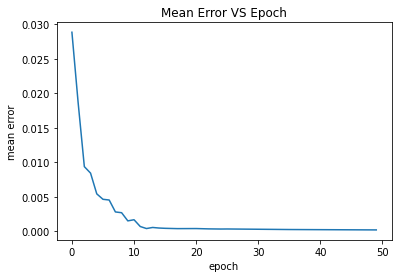

In [10]:
import matplotlib.pyplot as plt
plt.plot(result["epoch"], result["mean_error"])
plt.title("Mean Error VS Epoch")
plt.xlabel("epoch")
plt.ylabel("mean error")
plt.show()

Now we can test the model using the earlier 20% slice of the dataset. For the testing, the program will output the prediction and expected result if there is an error between them. After that, show the accuracy of the model

In [11]:
mean_error = 0
data_input = np.array(x_test)
data_output = np.array(y_test)
input("Press enter to start...")
result_test = {
    "n_data": [],
    "prediction": [],
    "output": [],
    "error": [],
    "mean_error": []
}
print("-----| Testing |-----")
for i in range(len(data_input)):
    temp_error = []
    h1_out, prediction = feed_forward(data_input[i], w_itoh, w_htoo, b)
    loss = error(data_output[i], prediction)
    result_test["error"] = np.append(result_test["error"], np.sum(loss))
    result_test["prediction"] = np.append(result_test["prediction"], np.argmax(prediction) + 1)
    if np.argmax(prediction) != np.argmax(data_output[i]):
        print("Prediction = {}, Output = {} Error!".format(np.argmax(prediction), np.argmax(data_output[i])))
    #else:
    #    print("Prediction = {}, Output = {}".format(np.argmax(prediction), np.argmax(data_output[i])))
    result_test["output"] = np.append(result_test["output"], np.argmax(data_output[i]) + 1)
    result_test["n_data"] = np.append(result_test["n_data"], i)
    temp_error = np.append(temp_error, loss)
    mean_error = np.mean(temp_error)
    for i in range(len(data_input)):
        result_test["mean_error"] = np.append(result_test["mean_error"], mean_error)

print("-----| Testing Finished |-----")
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(result_test["prediction"], result_test["output"])
print("Accuracy = {}%".format(accuracy * 100))

Press enter to start... 


-----| Testing |-----
Prediction = 9, Output = 7 Error!
Prediction = 5, Output = 3 Error!
Prediction = 7, Output = 9 Error!
Prediction = 2, Output = 5 Error!
Prediction = 1, Output = 8 Error!
Prediction = 5, Output = 8 Error!
Prediction = 5, Output = 6 Error!
Prediction = 6, Output = 5 Error!
-----| Testing Finished |-----
Accuracy = 97.77777777777777%


We can show the matrix confusion diagram to show the analysis of the testing session more clearly

----- Confusion matrix -----


<AxesSubplot:>

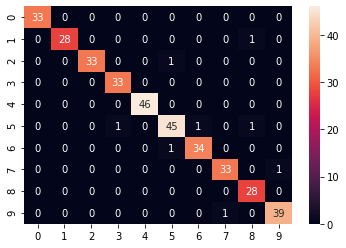

In [12]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(result_test["prediction"], result_test["output"])
print("----- Confusion matrix -----")
sns.heatmap(conf_matrix, annot=True)

So, for the conclusion, the BPNN architecture is very great for multiclass classification as seen by the testing session's accuracy (97.7%) above. 